# Parallel Computing with Earthdata in the Cloud
## Processing a Large Data Set in Chunks Using `coiled.cluster()`, Example Use for an SST Seasonal Cycle Analysis

#### *Authors: Dean Henze, NASA JPL PO.DAAC*

*Reference herein to any specific commercial product, process, or service by trade name, trademark, manufacturer, or otherwise, does not constitute or imply its endorsement by the United States Government or the Jet Propulsion Laboratory, California Institute of Technology.*

## Summary


Previous notebooks have covered the use of Dask and parallel computing applied to the type of tasks in the schematic below, where we have a function which needs to work on a large data set as a whole. This could e.g. because the function works on some or all of the data from each of the files, so we can't just work on each file independently like in the function replication example.

<img src="./schematic3.png" alt="sch1" width="500"/>
<img src="./schematic2.png" alt="sch1" width="500"/>

In a previous notebook, a toy example was used to demonstrate this basic functionality using a local dask cluster and Xarray built-in functions to work on the data set in chunks. In this notebook, we expand that workflow to a more complex analysis, representing something closer to a real-world use-case. In this notebook, we parallelize computations using the third party software/package `Coiled`. In short, `Coiled` will allow us to spin up AWS virtual machines (EC2 instances) and create a distributed cluster out of them, all with a few lines of Python from within this notebook. *You will need a Coiled account, but once set up, you can run this notebook entirely from your laptop while the parallel computation portion will be run on the distributed cluster in AWS.* 


#### Analysis: Mean Seasonal Cycle of SST Anomalies

The analysis will generate the mean seasonal cycle of sea surface temperature (SST) at each gridpoint in a region of the west coast of the U.S.A. 
The analysis uses a PO.DAAC hosted gridded global SST data sets:
* GHRSST Level 4 MUR Global Foundation SST Analysis, V4.1: 0.01° x 0.01° resolution, global map, daily files, https://doi.org/10.5067/GHGMR-4FJ04

The analysis will use files over the first decade of the time record. The files will be thinned out to once per week for the purposes of this notebook, but uncompressed the data will still be ~1.3 TB in memory. The following procedure is used to generate seasonal cycles:

<img src="./schematic_sst-cycle.png" alt="sch_sst-ssh-corr" width="800"/>


# ***!!!!Summarize section in this notebook!!!!***


## Requirements, prerequisite knowledge, learning outcomes

#### Requirements to run this notebook
* **Earthdata login account:** An Earthdata Login account is required to access data from the NASA Earthdata system. Please visit https://urs.earthdata.nasa.gov to register and manage your Earthdata Login account. 
* **Coiled account:** Create a coiled account (free to sign up), and connect it to an AWS account. For more information on Coiled, setting up an account, and connecting it to an AWS account, see their website https://www.coiled.io. 
* **Compute environment:** This notebook can be run either in the cloud (AWS instance running in us-west-2), or on a local compute environment (e.g. laptop, server), but the data loading step currently works substantially faster in the cloud. In both cases, the parallel computations are still sent to VM's in the cloud.


#### Prerequisite knowledge
* The [notebook on Dask basics](https://podaac.github.io/tutorials/notebooks/Advanced_cloud/basic_dask.html) and all prerequisites therein.

#### Learning outcomes
This notebook demonstrates how to use Coiled with a distributed cluster to replicate a function over many files in parallel. You will get better insight on how to apply this workflow to your own analysis.

## Import packages

We ran this notebook in a Python 3.12.3 environment. The minimal working install we used to run this notebook from a clean environment was:

*With pip:*

```
pip install xarray==2024.1.0 numpy==1.26.3 h5netcdf==1.3.0 "dask[complete]"==2024.5.2 earthaccess==0.9.0 matplotlib==3.8.0 coiled==1.28.0 jupyterlab
```

*or with conda:*

```
conda install -c conda-forge xarray==2024.1.0 numpy==1.26.3 h5netcdf==1.3.0 dask==2024.5.2 earthaccess==0.9.0 matplotlib==3.8.0 coiled==1.28.0 jupyterlab

In [2]:
## Version numbers listed next to each package:

# Data location and access packages:
import earthaccess                                 # 0.6.1

# Analysis packages:
import xarray as xr                                # 2023.9.0
import numpy as np                                 # 1.26.0

# Visualization packages:
import matplotlib.pyplot as plt                    # 3.8.0
%matplotlib inline

# Cloud computing / dask packages:
import coiled

In [3]:
xr.set_options( # display options for xarray objects
    display_expand_attrs=False,
    display_expand_coords=True,
    display_expand_data=True,
)

## 1. Locate MUR SST file access endpoints for first decade of record, inspect a file
We use `earthaccess` to find metadata and endpoints for the files.

In [4]:
earthaccess.login() # Login with your credentials

In [5]:
datainfo = earthaccess.search_data(
    short_name="MUR-JPL-L4-GLOB-v4.1",
    cloud_hosted=True,
    temporal=("2002-01-01", "2013-05-01"),
    )

Granules found: 3988


#### **Open and inspect a file**
Open a file and plot the SST data in the region for our analysis.

In [10]:
fileobj_test = earthaccess.open([datainfo[0]])[0] # Generate file objects from the endpoints which are compatible with Xarray
sst_test = xr.open_dataset(fileobj_test)['analysed_sst']
sst_test

Opening 1 granules, approx size: 0.32 GB


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

<xarray.DataArray 'analysed_sst' (time: 1, lat: 17999, lon: 36000)>
[647964000 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2002-06-01T09:00:00
  * lat      (lat) float32 -89.99 -89.98 -89.97 -89.96 ... 89.97 89.98 89.99
  * lon      (lon) float32 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Attributes: (7)

In [18]:
# Region to perform analysis over:
lat_region = (30, 45)
lon_region = (-135, -105)

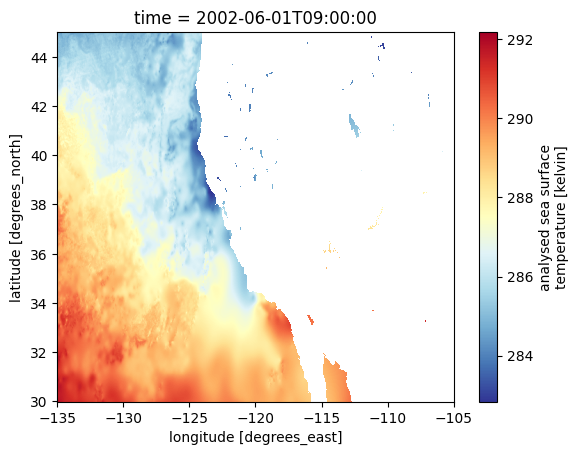

In [19]:
## Plot SST in analysis region:
fig = plt.figure()
sst_test.sel(lat=slice(*lat_region), lon=slice(*lon_region)).plot(cmap='RdYlBu_r')

#### **Memory considerations**
Demonstrating that these are fairly large files, especially uncompressed, at the time this notebook was written:

In [20]:
print("Disk size of one file =", datainfo[0]['size'], "MB.")

Disk size of one file = 332.3598403930664 MB.


In [22]:
print("Size in-memory of the SST variable once uncompressed =", sst_test.nbytes/10**9, "GB.")

Size in-memory of the SST variable once uncompressed = 2.591856 GB.


## 2. Seasonal cycle at weekly temporal resolution

In [ ]:
## Thin out data files to get weekly temporal resolution for this demo:
datainfo_thinned = [datainfo[i] for i in range(len(datainfo)) if i%7==0]

In [ ]:
## Confirm we have about a decade of files and at weekly resolution:
print("First and last file times \n--------------------------")
print(datainfo_thinned[0]['umm']['TemporalExtent']['RangeDateTime']['BeginningDateTime'])
print(datainfo_thinned[-1]['umm']['TemporalExtent']['RangeDateTime']['BeginningDateTime'])
print("\nFirst and second file times \n--------------------------")
print(datainfo_thinned[0]['umm']['TemporalExtent']['RangeDateTime']['BeginningDateTime'])
print(datainfo_thinned[1]['umm']['TemporalExtent']['RangeDateTime']['BeginningDateTime'])

In [ ]:
cluster = coiled.Cluster(
    n_workers=25, 
    region="us-west-2", 
    worker_vm_types="c7g.large", # or can try "m7a.medium"
    scheduler_vm_types="c7g.large" # or can try "m7a.medium"
    ) 
client = cluster.get_client()

In [ ]:
%%time
fileobjs = earthaccess.open(datainfo_thinned) # Generate file objects from the endpoints which are compatible with Xarray

In [ ]:
%%time

## Load files and rechunk SST data:
murdata = xr.open_mfdataset(fileobjs, parallel=True, chunks={'lat': 6000, 'lon': 6000, 'time': 1})
sst = murdata["analysed_sst"]
sst = sst.chunk(chunks={'lat': 500, 'lon': 500, 'time': 200})
sst

In [ ]:
## ----------------
## Set up analysis
## ----------------
## (Since we're dealing with dask arrays, these functions calls don't do the computations yet, just set them up)

## Subset to region off U.S.A. west coast:
sst_regional = sst.sel(lat=slice(*lat_region), lon=slice(*lon_region))

## Remove linear warming trend:
p = sst_regional.polyfit(dim='time', deg=1) # Degree 1 polynomial fit coefficients over time for each lat, lon.
fit = xr.polyval(sst_regional['time'], p.polyfit_coefficients) # Compute linear trend time series at each lat, lon.
sst_detrend = (sst_regional - fit) # xarray is smart enough to subtract along the time dim only.

## Mean seasonal cycle:
seasonal_cycle = sst_detrend.groupby("time.month").mean("time")

In [ ]:
%%time
## ----------------
## Compute it all!!
## ----------------
seasonal_cycle = seasonal_cycle.compute()
cluster.scale(1)

In [ ]:
client.shutdown()
cluster.shutdown()

#### **Plot results**

In [ ]:
# Points to plot seasonal cycle at:
lat_points = (38, 38, 38, 38)
lon_points = (-123.25, -125, -128, -132)

In [ ]:
fig2, axes2 = plt.subplots(1, 2, figsize=(12, 4))

## Replot the map and points from the test file:
sst_test.sel(lat=slice(*lat_region), lon=slice(*lon_region)).plot(ax=axes2[0], cmap='RdYlBu_r')
for lat, lon in zip(lat_points, lon_points):
    axes2[0].scatter(lon, lat)

## Seasonal cycles on another plot
for lat, lon in zip(lat_points, lon_points):
    scycle_point = seasonal_cycle.sel(lat=lat, lon=lon)
    axes2[1].plot(scycle_point['month'], scycle_point.values, 'o-')

axes2[1].set_title("Seasonal cycle of temperature anomalies \n at four test points", fontsize=14)
axes2[1].set_xlabel("month", fontsize=12)
axes2[1].set_ylabel(r"$\Delta$T (K)", fontsize=12)

## 3. Seasonal cycle for full record (daily resolution)
Currently I have had success with one file per 3 days. With ~40 workers c7i.xlarge, takes about 6 minutes.

In [ ]:
datainfo_thinned = [datainfo[i] for i in range(len(datainfo)) if i%3==0]
fileobjs = earthaccess.open(datainfo_thinned) # Generate file objects from the endpoints which are compatible with Xarray

In [ ]:
cluster = coiled.Cluster(
    n_workers=40, 
    region="us-west-2", 
    worker_vm_types="c7g.xlarge",
    scheduler_vm_types="c7g.xlarge"
    ) 
client = cluster.get_client()

In [ ]:
%%time

## Load files and rechunk SST data:
murdata = xr.open_mfdataset(fileobjs, parallel=True, chunks={'lat': 6000, 'lon': 6000, 'time': 1})
sst = murdata["analysed_sst"]
sst = sst.chunk(chunks={'lat': 500, 'lon': 500, 'time': 400})
sst

In [ ]:
## ----------------
## Set up analysis
## ----------------
## (Since we're dealing with dask arrays, these functions calls don't do the computations yet, just set them up)

## Subset to region off U.S.A. west coast:
sst_regional = sst.sel(lat=slice(*lat_region), lon=slice(*lon_region))

## Remove linear warming trend:
p = sst_regional.polyfit(dim='time', deg=1) # Degree 1 polynomial fit coefficients over time for each lat, lon.
fit = xr.polyval(sst_regional['time'], p.polyfit_coefficients) # Compute linear trend time series at each lat, lon.
sst_detrend = (sst_regional - fit) # xarray is smart enough to subtract along the time dim only.

## Mean seasonal cycle:
seasonal_cycle = sst_detrend.groupby("time.month").mean("time")

In [ ]:
%%time
## ----------------
## Compute it all!!
## ----------------
seasonal_cycle = seasonal_cycle.compute()
cluster.scale(1)